## TLDR
Tests pour sinkhorn et les buiders.
J'ai utilisé de 2 images arbitraires téléchargées dans un a dataset pour faire mes tests.
Pour les résultats, lire les sections conclusion des tests.

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline
%load_ext autoreload
%autoreload 2

from sinkhorn import sinkhorn
from builders import image2array, array2cost, image2array, transfer_color, array2image

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Tests of Sinkhorn() with exact Gibbs kernel
### Initialization of managable variables:

In [28]:
# Points:
n=100**2 
x = np.linspace(0,1,n)
y = np.linspace(0,1,n)
x=x[:,np.newaxis]
y=y[:,np.newaxis]
# Cost:
C = (x-y.T)**2
# entropy factor:
eta = 1 # il manque W <- W/eta dans l'algo alors garder eta=1
# (exact) Kernel:
Kmat = np.exp(-eta*C)
def K(v):
    return Kmat@v
def Kt(v):
    return (Kmat.T)@v
# Target marginals:
p = np.ones((n,1))
p = p / np.sum(p)
q = np.ones((n,1))
q = q / np.sum(q) 
# tolerance:
delta = 1e-15

### Sinkhorn projection computation:

W = -18.267731769488172
W = -18.267731769488144 (with other calculation)
Marginal error: 2.3889039618002483e-16


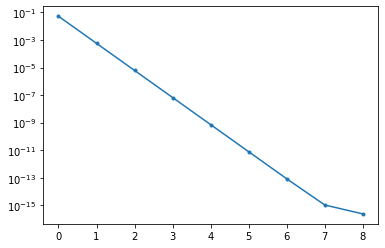

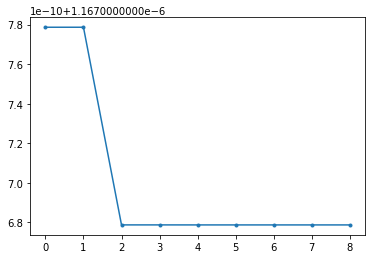

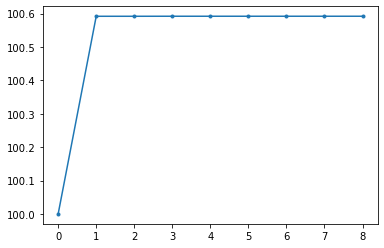

In [29]:
# Sinkhorn:
u,v,W,norm_u,norm_v,err = sinkhorn(K,Kt,p,q,delta,maxtime=10)
# Coupling:
P = u*Kmat*v.T
# Objective function:
Wbis = np.sum(C*P) - 1/eta * np.sum(P * np.log(1/P))
# Display:
print("W =",W)
print("W =",Wbis,"(with other calculation)")
print("Marginal error:",err[-1])
plt.semilogy(err,".-")
plt.figure()
plt.plot(norm_u,".-")
plt.figure()
plt.plot(norm_v,".-")

### Conclusions of test 1.
`Sinkhorn()` **Seem now to work well**. Marginal error **converge to zero with high precision and quite fast** for dimensions under $100^2$. The scallings vectors norms converge also to a certain value, showing the **stability of the convergence**. They do not necessarily have the same amplitude.

It remains to understand if the coding line that **increase the suport** is usefull.

Note que $W$ est **calculé faux dans le paper**, il manque un facteur $\eta^{-1}$, c'est embêtant parce $\eta$ est pas un paramètre de Sinkhorn mais caché dans le $K$. **Garder $\eta=1$** pour éviter le problème...

## 2. Tests de builders.py
Images produites par `getPictures.m`
### Initialisation des variables:


In [56]:
N = 100 # largeur de l'image (=longeur)
n = N^2 # nombre de pixels
img1 = image2array('img1_'+str(N)+'.jpg')
img2 = image2array('img2_'+str(N)+'.jpg')
img3 = image2array('img3_'+str(N)+'.jpg')
C, m1, m2 = array2cost(img1, img2)
#C = C/1 # pour pas qu'il soit trop grand.
eta = 1
Kmat = np.exp(-eta*C)
def K(v):
    return Kmat@v
def Kt(v):
    return (Kmat.T)@v
delta = 1e-10

### Sinkhorn projection computation:

In [57]:
u,v,W,norm_u,norm_v,err = sinkhorn(K,Kt,m1,m2,delta,maxtime=10)
# Coupling:
P = u*Kmat*v.T
# Objective function:
Wbis = np.sum(C*P) - 1/eta * np.sum(P * np.log(1/P))

W = -17.775072350280823
W / 1 = -17.775072350280777 (with other calculation)
Marginal error: 2.2626165386272802e-11
sum P = 1.0000000000000036
max P = 2.7222445366491605e-08
min P = 4.915602948920671e-10
max img1 = 0.99609375
min img1 = 0.0
max img12 = 4.173856291788605e-05
min img12 = 1.4607091584784947e-05


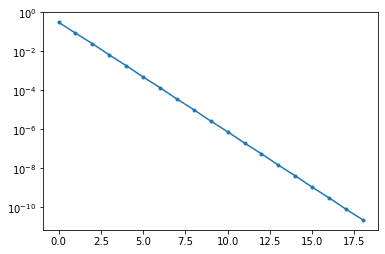

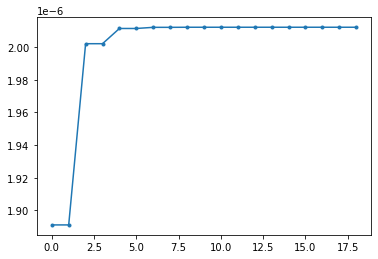

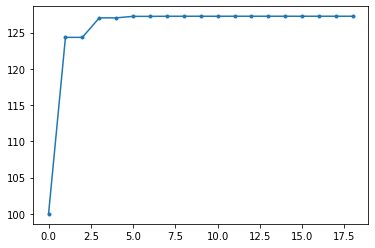

In [60]:
# Display evolution:
print("W =",W)
print("W /",eta,"=",Wbis,"(with other calculation)")
print("Marginal error:",err[-1])
plt.semilogy(err,".-")
plt.figure()
plt.plot(norm_u,".-")
plt.figure()
plt.plot(norm_v,".-")
print("sum P =",np.sum(P))
print("max P =",np.max(P))
print("min P =",np.min(P))
#plt.matshow(P)
#plt.matshow(Kmat)
# Compute resulting image
img12=transfer_color(P,img1)
array2image('img12.jpg', img12)
print("max img1 =",np.max(img1))
print("min img1 =",np.min(img1))
print("max img12 =",np.max(img12))
print("min img12 =",np.min(img12))

### Conclusions du test 2. builders.py:
- les builders semblent bien marcher
- la pixelisation du TA fonctionne bien, je run son fichier dans MATLAB et je save les images en `.jpg` dans le dossier pour les utiliser avec nos builders.
- L'image finale `img12` est toute noire, ses valeures sont minsucules. Le P obtenu est bien un coupling,